In [107]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [108]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import joblib

# Load Data
file_path = r"C:\Users\Precious\Downloads\heart_attack_youth_vs_adult_nigeria.csv"
df = pd.read_csv(file_path, na_values=['']) 
print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

Dataset loaded successfully!
Dataset shape: (898796, 19)



--- Data Exploration ---
First few rows of the dataset:
     State Age_Group  Gender   BMI Smoking_Status Alcohol_Consumption  \
0     Ondo     Youth  Female  34.5     Non-Smoker                High   
1      FCT     Youth    Male  15.2     Non-Smoker                High   
2    Borno     Youth  Female  25.0     Non-Smoker                High   
3  Katsina     Youth    Male  19.7     Non-Smoker                High   
4   Kaduna     Adult  Female  35.6     Non-Smoker                 Low   

  Exercise_Frequency Hypertension Diabetes Cholesterol_Level Family_History  \
0       Occasionally           No      Yes        Borderline            Yes   
1       Occasionally           No      Yes              High             No   
2             Weekly           No      Yes              High             No   
3       Occasionally           No       No              High            Yes   
4             Rarely           No      Yes              High            Yes   

  Stress_Level  Diet_Type Hea

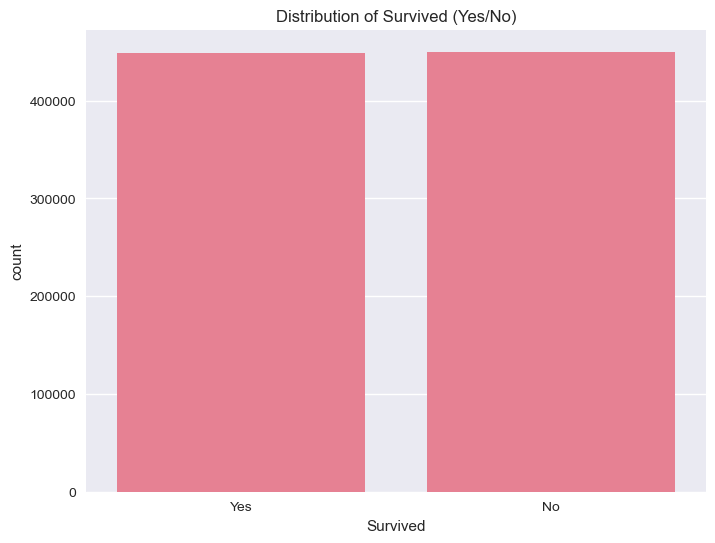

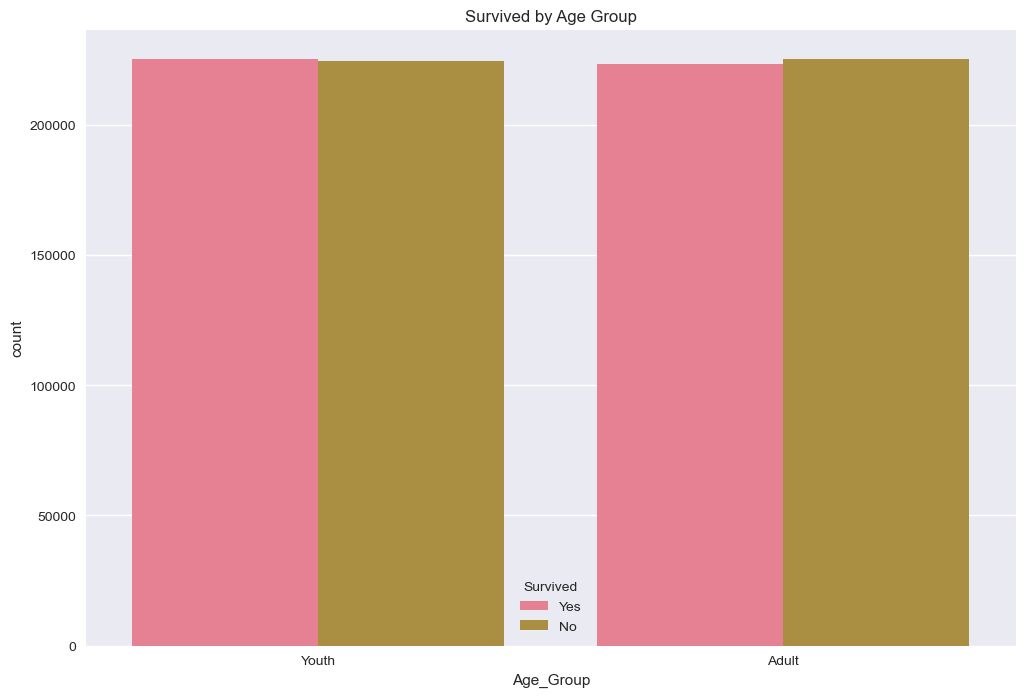

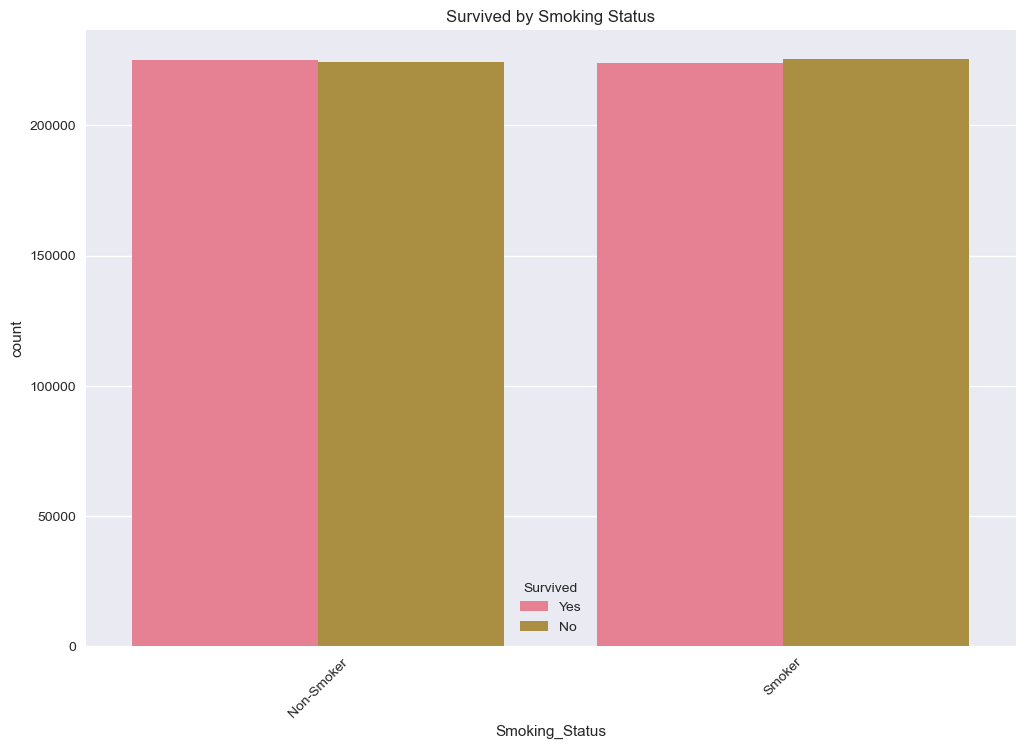

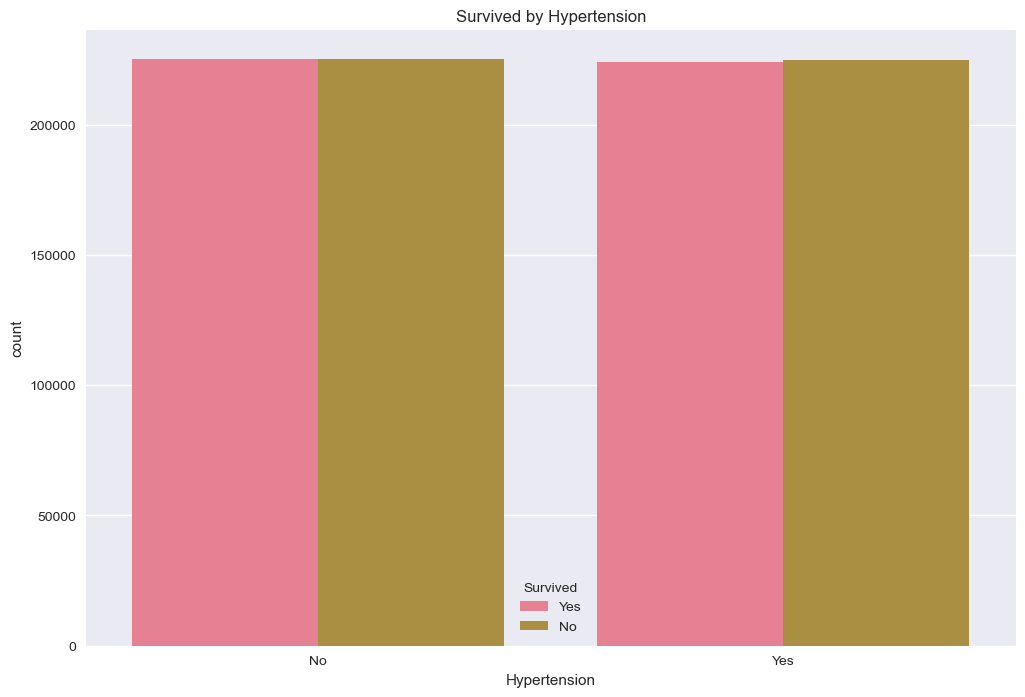

In [109]:
# Data Exploration
print("\n--- Data Exploration ---")
print("First few rows of the dataset:")
print(df.head())

# Basic summary statistics
print("\nSummary Statistics:")
print(df.describe(include='all'))

# Check for missing values (excluding "None" as a valid category)
print("\nMissing Values (excluding 'None' as a valid category):")
print(df.replace('None', np.nan).isnull().sum())

# Distribution of the target variable ('Survived')
print("\nDistribution of 'Survived':")
print(df['Survived'].value_counts(normalize=True))

# Visualize distribution of 'Survived'
plt.figure(figsize=(8, 6))
sns.countplot(x='Survived', data=df)
plt.title('Distribution of Survived (Yes/No)')
plt.show()

# Visualize key categorical features vs. 'Survived'
plt.figure(figsize=(12, 8))
sns.countplot(x='Age_Group', hue='Survived', data=df)
plt.title('Survived by Age Group')
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(x='Smoking_Status', hue='Survived', data=df)
plt.title('Survived by Smoking Status')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 8))
sns.countplot(x='Hypertension', hue='Survived', data=df)
plt.title('Survived by Hypertension')
plt.show()

In [110]:
# 3. Data Cleaning
print("\n--- Data Cleaning ---")
# Drop duplicates if any
initial_rows = len(df)
df = df.drop_duplicates()
print(f"Dropped {initial_rows - len(df)} duplicate rows.")

# Handle missing values (if any), but preserve "None" as a valid category
if df.replace('None', np.nan).isnull().sum().any():
    # Impute missing numerical values with median (excluding "None")
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].median())
    
    # Impute missing categorical values with mode, but ensure "None" is not treated as missing
    categorical_columns = df.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        # Replace only actual NaN values (not "None") with mode
        df[col] = df[col].replace(np.nan, df[col].mode()[0])


--- Data Cleaning ---
Dropped 598796 duplicate rows.


In [111]:
# Feature Engineering
print("\n--- Feature Engineering ---")
# Check if 'Survived' exists and determine its type
if 'Survived' not in df.columns:
    raise KeyError("Column 'Survived' not found in the DataFrame.")

# Ensure 'Survived' is categorical (object) or numeric (0/1)
if df['Survived'].dtype == 'object':
    print("Encoding 'Survived' as categorical...")
    # Verify valid values before encoding
    if not all(value in ['Yes', 'No'] for value in df['Survived'].unique()):
        raise ValueError("Unexpected values in 'Survived' column. Expected 'Yes' or 'No'.")
    df['Survived'] = df['Survived'].map({'Yes': 1, 'No': 0})
elif df['Survived'].dtype in ['int64', 'float64']:
    print("'Survived' is already numeric. Ensuring binary values (0/1)...")
    # Ensure 'Survived' contains only 0 and 1
    if not all(value in [0, 1] for value in df['Survived'].unique()):
        raise ValueError("Non-binary values found in 'Survived'. Expected 0 or 1.")
else:
    raise ValueError(f"Unexpected dtype for 'Survived': {df['Survived'].dtype}")

# Encode categorical variables (excluding 'Survived'), ensuring "None" is preserved as a valid category
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns  # Include all object columns, handle 'Survived' separately

# Encode other categorical columns, handling "None"
for column in categorical_columns:
    if column != 'Survived':  # Skip 'Survived' since it's handled separately
        # Ensure "None" is treated as a valid category
        if 'None' in df[column].values:
            df[column] = df[column].replace('None', 'No_Alcohol' if column == 'Alcohol_Consumption' else 'No_' + column)  # Rename "None" to avoid confusion
        # Check for valid categorical values before encoding
        if df[column].isnull().any():
            raise ValueError(f"Missing values found in column '{column}' after cleaning.")
        label_encoders[column] = LabelEncoder()
        df[column] = label_encoders[column].fit_transform(df[column])

# Scale only numerical features (e.g., BMI), not the target
scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.drop('Survived')  # Exclude 'Survived'
X_features = df.drop('Survived', axis=1)  # Features (X) only, excluding 'Survived'
if not numerical_columns.empty:
    X_features[numerical_columns] = scaler.fit_transform(X_features[numerical_columns])
else:
    print("No numerical columns found to scale.")

# Reconstruct the DataFrame with scaled features and unscaled target
df_scaled = pd.concat([X_features, df['Survived']], axis=1)

print("\n--- Saving Encoders and Scaler ---")
# Save label_encoders
joblib.dump(label_encoders, 'label_encoders.pkl')
# Save scaler
joblib.dump(scaler, 'scaler.pkl')
print("Encoders and scaler saved successfully!")


--- Feature Engineering ---
Encoding 'Survived' as categorical...

--- Saving Encoders and Scaler ---
Encoders and scaler saved successfully!


In [112]:
# 5. Data Splitting (75% Train/Validation, 25% Test, with Validation Split)
print("\n--- Data Splitting ---")
# Split features and target (using scaled features and unscaled target)
X = df_scaled.drop('Survived', axis=1)
y = df_scaled['Survived']

# First, split into 75% (train+validation) and 25% (test), stratified by 'Survived'
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Then, split the 75% into 80% train (60% of full) and 20% validation (15% of full), stratified
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42, stratify=y_temp)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Testing set shape: {X_test.shape}")


--- Data Splitting ---
Training set shape: (180000, 18)
Validation set shape: (45000, 18)
Testing set shape: (75000, 18)



--- Feature Selection and Model Training ---

Feature Importance (Top 10):
                Feature  Importance
2                Gender    0.060053
17    Employment_Status    0.058511
5   Alcohol_Consumption    0.058178
8              Diabetes    0.057656
0                 State    0.055939
1             Age_Group    0.055873
9     Cholesterol_Level    0.055767
4        Smoking_Status    0.055591
12            Diet_Type    0.055503
11         Stress_Level    0.055172


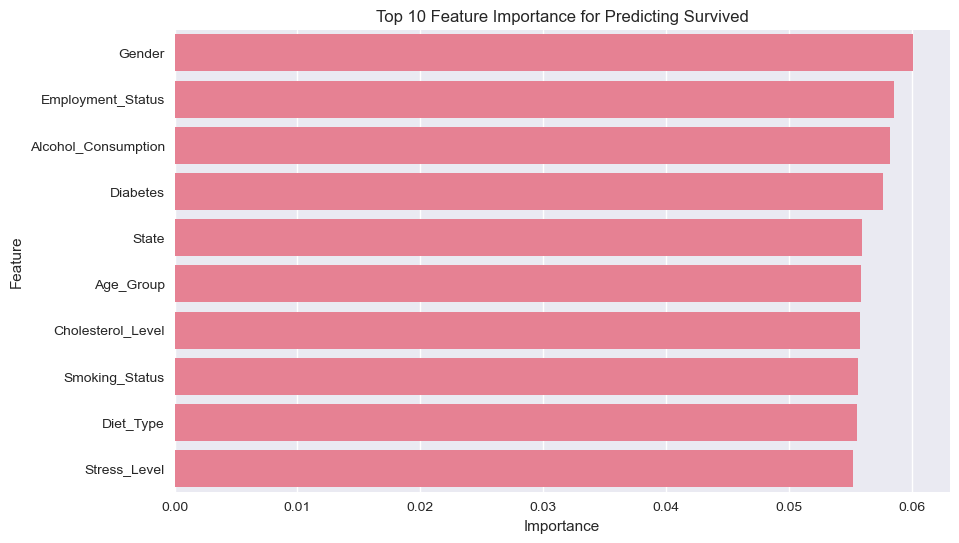


Model Performance on Validation Set:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     22523
           1       0.50      0.50      0.50     22477

    accuracy                           0.50     45000
   macro avg       0.50      0.50      0.50     45000
weighted avg       0.50      0.50      0.50     45000

Validation Accuracy: 0.50

Model Performance on Test Set (25% of Data):
              precision    recall  f1-score   support

           0       0.50      0.51      0.51     37539
           1       0.50      0.50      0.50     37461

    accuracy                           0.50     75000
   macro avg       0.50      0.50      0.50     75000
weighted avg       0.50      0.50      0.50     75000

Test Accuracy: 0.50


In [113]:
# 6. Feature Selection and Model Training
print("\n--- Feature Selection and Model Training ---")

# Train a small XGBoost model on the training set to get feature importance
model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)  # Removed `use_label_encoder`
model.fit(X_train, y_train)

# Get feature importance
importance = model.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

print("\nFeature Importance (Top 10):")
print(importance_df.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importance for Predicting Survived')
plt.show()

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)
print("\nModel Performance on Validation Set:")
print(classification_report(y_val, y_val_pred))
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.2f}")

# Evaluate the model on the test set (25% of data)
y_test_pred = model.predict(X_test)
print("\nModel Performance on Test Set (25% of Data):")
print(classification_report(y_test, y_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")

In [114]:
# Save model as .pkl 
print("\n--- Saving Model ---")
model_filename = "NigeriaHeartAttack.pkl"
joblib.dump(model, model_filename)
print(f"Model saved successfully as {model_filename}")


--- Saving Model ---
Model saved successfully as NigeriaHeartAttack.pkl
